# Enoncé
## Contexte
**Mon rôle** : Data Scientist au sein de l’entreprise "Place de marché”

**Commanditaire** : Place de marché (https://olist.com/pt-br/)

**Activité de l'entreprise :** mettre en relation vendeurs et acheteurs

**Projet :** lancer une marketplace e-commerce

**Type de Mission :** classification non supervisés

## Attendus
**But de la mission :** étudier la *faisabilité d'un moteur de classification* des articles en différentes catégories

**Détails de la mission :** 

données ==> https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Textimage+DAS+V2/Dataset+projet+pre%CC%81traitement+textes+images.zip

**Problèmes :** 

Afin d’extraire les *features texte*, il sera nécessaire de mettre en œuvre : 
- deux approches de type “bag-of-words”, comptage simple de mots et Tf-idf ;
- une approche de type word/sentence embedding classique avec Word2Vec (ou Glove ou FastText) ;
- une approche de type word/sentence embedding avec BERT ;
- une approche de type word/sentence embedding avec USE (Universal Sentence Encoder).

*exemple* de mise en œuvre de ces approches sur un autre dataset (l’utiliser comme point de départ) : https://s3.eu-west-1.amazonaws.com/course.oc-static.com/projects/Data_Scientist_P6/Exemple_Tweets_Feature-extraction_Sentence+Embedding_V1.1.ipynb

Afin d’extraire les *features image*, il sera nécessaire de mettre en œuvre :
- un algorithme de type SIFT / ORB / SURF ;
- un algorithme de type CNN Transfer Learning.

**Etapes demandées :**

- analyser le jeu de données en réalisant un *prétraitement des descriptions des produits et des images*
- une *réduction de dimension*
- un *clustering*

/!\ Les résultats de la réduction de dimension et du clustering seront à présenter sous la forme de *graphiques en deux dimensions*, et confirmés par un *calcul de similarité* entre les catégories réelles et les clusters (*ARI ?*) ==> les caractéristiques extraites permettent de regrouper des produits de même catégorie. /!\

**Script concerné :** 

- **Un notebook (ou des fichiers .py) contenant les fonctions permettant le prétraitement des données textes et images ainsi que les résultats du clustering (en y incluant des représentations graphiques).**
- Un support de présentation qui présente la démarche et les résultats du clustering.

# Librairies, paramétrages et données
## Mise à jour des librairies

## Importations des librairies

In [1]:
# Gestion des données
import pandas as pd
import numpy as np
import string
from collections import Counter
import time

# Gestion des graphiques
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from functions import *

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, LancasterStemmer
'''nltk.download('punkt')
nltk.download('stopwords')
nltk.download('words')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('brown')
nltk.download('omw-1.4')'''

from gensim.models.word2vec import Word2Vec
#from gensim.utils import simple_preprocess
#import gensim.downloader as api
#model = api.load("word2vec-google-news-300")

from transformers import AutoTokenizer, TFAutoModel
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import tensorflow_hub as hub

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import decomposition
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics.cluster import adjusted_rand_score

# Algo CNN Transfert Learning
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16
from keras.layers import Dense
from keras import Model

# Algo SIFT
import cv2

# disable WARNING, INFO and DEBUG logging everywhere
import logging
logging.disable(logging.WARNING) 

## Paramétrages

In [2]:
# Format des résultats affichés
pd.set_option('display.max_columns', None) # display.max_columns : contrôle le nombre de colonnes à imprimer (int ou None pour imprimer toutes les colonnes)
pd.set_option('max_colwidth', 100) # Vous pouvez augmenter la largeur en passant un int (ou mettre au max en passant None)
pd.set_option("display.max_rows", 100) # Pour modifier le nombre de lignes, vous devez modifier l' option max_rows 
pd.options.display.float_format = '{:.4f}'.format # enlève le format d'affichage : nombre scientifique

# Pour afficher les graphiques dans la continuité du code, et non pas dans une fenêtre à part:
%matplotlib inline

# ignore les warnings
import warnings
warnings.filterwarnings("ignore")

## Importations des données

In [3]:
df = pd.read_csv('E:/Formations/6. Diplôme Data Scientist/Projet/Projet-6/Flipkart/flipkart_com-ecommerce_sample_1050.csv'
                 , sep=","
                 , decimal = '.'
                 , encoding="utf-8")

path = "C:/Users/bland/Downloads/Images/"

# Nettoyage
## Visualisation générale

In [4]:
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdg...,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,"[""Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstrac...",CRNEG7BKMFFYHQ8Z,1899.0000,899.0000,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan...",No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""value""=>""Elegance""}, {""key""=>""Designed For"", ""value..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-towel/p/itmegfzhxbyucwgn?pid=BTWEGFZHGBXPHZUH,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cot...",BTWEGFZHGBXPHZUH,600.0000,449.0000,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,"Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Featur...",No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Washable"", ""value""=>""Yes""}, {""key""=>""Material"", ""val..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-face-towel-set/p/itmeg6shbrpubhca?pid=BTWEG6SHXTDB2A2Y,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Eurospa Baby Bath Towels >> Eurospa Cotto...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,"Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa ...",No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"", ""value""=>""Cotton Terry""}, {""key""=>""Design"", ""valu..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-cotton-printed-king-sized-double-bedsheet/p/itmejt...,SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet,"[""Home Furnishing >> Bed Linen >> Bedsheets >> SANTOSH ROYAL FASHION Bedsheets >> SANTOSH ROYAL ...",BDSEJT9UQWHDUBH4,2699.0000,1299.0000,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet Royal Bedsheet P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""value""=>""SANTOSH ROYAL FASHION""}, {""key""=>""Machine ..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-floral-king-sized-double-bedsheet/p/itmejthnwahrnt7v...,Jaipur Print Cotton Floral King sized Double Bedsheet,"[""Home Furnishing >> Bed Linen >> Bedsheets >> Jaipur Print Bedsheets >> Jaipur Print Cotton Flo...",BDSEJTHNGWVGWWQU,2599.0000,698.0000,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,"Key Features of Jaipur Print Cotton Floral King sized Double Bedsheet 100% cotton,Jaipur Print C...",No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Washable"", ""value""=>""Yes""}, {""key""=>""Brand"", ""value""..."


## Doublons et valeurs manquantes

In [5]:
df.loc[df['product_rating'] == 'No rating available', 'product_rating'] = np.nan
df.loc[df['overall_rating'] == 'No rating available', 'overall_rating'] = np.nan

In [6]:
print('Il y a {:,} lignes dans le df et {:,} colonnes.'.format(df.shape[0],df.shape[1]).replace(',',' '))

Il y a 1 050 lignes dans le df et 15 colonnes.


Je vais regarder s'il y a des produits en double, par l'id ou par le nom.

In [7]:
print('Il y a {} doublons.'.format(df.duplicated(subset=['uniq_id']).sum()))

Il y a 0 doublons.


In [8]:
print('Il y a {} doublons.'.format(df.duplicated(subset=['product_name']).sum()))

Il y a 0 doublons.


Aucun doublon dans les produits, je vais maintenant regarder les données et les valeurs manquantes que l'on a.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           161 non-null    object 
 12  overall_rating           161 non-null    object 
 13  brand                    712 non-null    object 
 14  product_specifications  

Je peux voir qu'il y a beaucoup d'informations concernant les produits, mais seul quelques informations nous intéresse ici : 
- son *identifiant* (pour les différencier) ==> **uniq_id**
- leur *catégorie* (pour avoir les vrais valeurs à trouver) ==> **product_category_tree**
- leur *description* ==> **description** 
- leur *image* ==> **image**

De plus, il n'y a aucune valeur manquantes dans les données à conserver. Je peux donc supprimer les autres.

## Filtrage des colonnes

In [10]:
df = df[['uniq_id', 'product_category_tree', 'image', 'description']]

## Pre-processing

In [11]:
df.describe(include = 'all')

,uniq_id,product_category_tree,image,description
count,1050,1050,1050,1050
unique,1050,642,1050,1050
top,55b85ea15a1536d46b7190ad6fff8ce7,"[""Home Furnishing >> Bed Linen >> Blankets, Quilts & Dohars""]",55b85ea15a1536d46b7190ad6fff8ce7.jpg,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan..."
freq,1,56,1,1


Je peux voir que la categorie du produit renvoie en vérité une hiérarchie de catégorie de produit. Je vais diviser cette donnée pour avoir les principales catégories.

### Catégorie du produit

In [12]:
# je transforme en list cette donnée
df_temp = df.product_category_tree.str.replace('["','', regex = False
                                    ).str.replace('"]','', regex = False
                                                 ).str.split(' >> ', expand = True)
# je ne garde que les premières catégories les plus remplies
df_temp = df_temp.loc[:,df_temp.isna().sum() < 10]

# je créé la list des noms des colonnes de catégories de produit gardées
idx = []
for i in range(0,df_temp.shape[1]):
    idx.append('product_category_'+str(i+1))
    
# je transforme le nom des colonnes
df_temp.columns = idx

# j'ajoute ce df temporaire au df principal
df = pd.concat([df,df_temp], axis = 1)
del df_temp, idx
df.drop(columns = ['product_category_tree'], inplace = True)
df.head()

,uniq_id,image,description,product_category_1,product_category_2,product_category_3
0,55b85ea15a1536d46b7190ad6fff8ce7,55b85ea15a1536d46b7190ad6fff8ce7.jpg,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan...",Home Furnishing,Curtains & Accessories,Curtains
1,7b72c92c2f6c40268628ec5f14c6d590,7b72c92c2f6c40268628ec5f14c6d590.jpg,"Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Featur...",Baby Care,Baby Bath & Skin,Baby Bath Towels
2,64d5d4a258243731dc7bbb1eef49ad74,64d5d4a258243731dc7bbb1eef49ad74.jpg,"Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa ...",Baby Care,Baby Bath & Skin,Baby Bath Towels
3,d4684dcdc759dd9cdf41504698d737d8,d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet Royal Bedsheet P...,Home Furnishing,Bed Linen,Bedsheets
4,6325b6870c54cd47be6ebfbffa620ec7,6325b6870c54cd47be6ebfbffa620ec7.jpg,"Key Features of Jaipur Print Cotton Floral King sized Double Bedsheet 100% cotton,Jaipur Print C...",Home Furnishing,Bed Linen,Bedsheets


In [13]:
listColCat = df.columns.tolist()
listColCat = [x for x in listColCat if 'product_category' in x]
listColCat

['product_category_1', 'product_category_2', 'product_category_3']

Maintenant que j'ai bien séparer ma hiérarchie de catégorie de produit, il faut que j'en choisisse une seule pour construire ma classification. En effet, aucune indication n'a été donné par le commanditaire concernant le niveau de catégorie de produit sur lequel travailler.

Je vais regarder du côté des modalités, valeurs uniques.

In [14]:
for var in listColCat:
    print(var,':',df[var].isna().sum(),'ligne(s) vide(s) ;',df[var].nunique(),'modalités.')

product_category_1 : 0 ligne(s) vide(s) ; 7 modalités.
product_category_2 : 0 ligne(s) vide(s) ; 62 modalités.
product_category_3 : 3 ligne(s) vide(s) ; 241 modalités.


Ici, 2 hiérarchie de catégorie de produit sont complètement remplies. La principal catégorie du produit ('product_category_1') comprends beaucoup moins de modalités, 7, que la sous-catégorie du produit ('product_category_2'), 62. Je vais tout de même regarder la répartition des 2 hiérarchie de catégorie avant de faire mon choix.

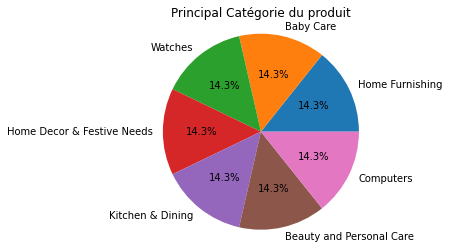

In [15]:
df["product_category_1"].value_counts(normalize=True).plot(kind = 'pie', autopct = '%1.1f%%', label = '')
plt.axis('equal')
plt.title('Principal Catégorie du produit')
plt.show();

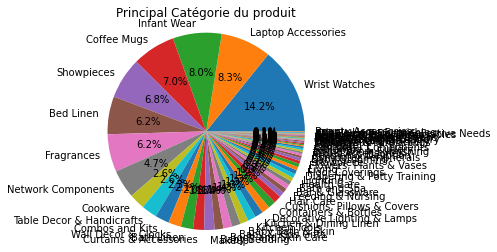

In [16]:
df["product_category_2"].value_counts(normalize=True).plot(kind = 'pie', autopct = '%1.1f%%', label = '')
plt.axis('equal')
plt.title('Principal Catégorie du produit')
plt.show();

En plus de comprendre moins de catégorie de produit, elle est proportionnellement représentée entre toutes ses modalités. Je vais donc choisir la principale catégorie de produit, product_category_1, pour ma classification.

In [17]:
df = df.drop(columns = listColCat[1:])
df = df.rename(columns = {listColCat[0]:'product_category'})
df.head()

,uniq_id,image,description,product_category
0,55b85ea15a1536d46b7190ad6fff8ce7,55b85ea15a1536d46b7190ad6fff8ce7.jpg,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan...",Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590,7b72c92c2f6c40268628ec5f14c6d590.jpg,"Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Featur...",Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74,64d5d4a258243731dc7bbb1eef49ad74.jpg,"Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa ...",Baby Care
3,d4684dcdc759dd9cdf41504698d737d8,d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet Royal Bedsheet P...,Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7,6325b6870c54cd47be6ebfbffa620ec7.jpg,"Key Features of Jaipur Print Cotton Floral King sized Double Bedsheet 100% cotton,Jaipur Print C...",Home Furnishing


Je dois maintenant passer au nettoyage de mes features sur lesquelles mon modèle va se baser pour prédire la catégorie du produit : la description et l'image du produit.

Je vais commencer par nettoyer la description du produit.

### Description du produit

Pour cela, je vais appliquer plusieurs transformations :
- je vais d'abord mettre toutes les descriptions en minuscule et leur supprimer tout ce qui n'est pas du texte (les ponctuations, les chiffres)
- je vais ensuite transformer le texte en liste de mots
- de ces listes, je vais supprimer tout ce qui n'est pas informatif (stopword, mots courts, ...)
- je vais transformer les mots restant de sorte à ne garder que leur forme pure (infinitif des verbes, racine des noms, ...)
- enfin, je vais supprimer les mots apparaissant dans moins de 1% ou plus de 80% des descriptions produits.

In [18]:
def prep_control(series):
    if isinstance(series.iloc[0], list):
        series_join = series.apply(lambda x: ' '.join([item for item in x]))
        all_words = ' '.join(sorted([word for word in series_join]))
        vocab = sorted(np.unique(all_words.split(' ')))
        print('---------')
        print('Il y a {} mots différents dans les descriptions.'.format(len(vocab)))
        indexes = np.unique(series.iloc[0], return_index = True)[1]
        example = [series.iloc[0][index] for index in sorted(indexes)]
        print('Sentence example :', example)
        print('---------')
    else:
        all_words = ' '.join(sorted([word for word in series]))
        vocab = sorted(np.unique(all_words.split(' ')))
        print('Il y a {} mots différents dans les descriptions.'.format(len(vocab)))
        print('Sentence example :', series.iloc[0])

def prep_cleaning(series):
    
    print('Cleaning in progress ...')
    
    # lower case
    series = series.str.lower()
    # delete punctuation
    series = series.str.translate({ord(x): ' ' for x in list(string.punctuation)})
    # delete extra space
    series = series.str.replace('\s\s', ' ', regex = True)
    # delete number
    series = series.str.replace('[a-z]*[0-9]', '', regex = True)
    # delete extra space
    series = series.str.replace('\s\s', ' ', regex = True)
    
    print('... finished')
    print('---------')
    
    prep_control(series)
    
    return series

def prep_token(series):
    
    print('Tokenizer in progress ...')
    
    tokenizer = nltk.RegexpTokenizer(r'\w+')
    series = series.apply(tokenizer.tokenize)
    
    print('... finished')
    print('---------')
    
    prep_control(series)
    
    return series

def prep_stopWords(series):    # suppression des mots sans valeur informative (de, a, comme, ...)
    
    print('Delete stop words in progress ...')
    
    stopwords = nltk.corpus.stopwords.words("english")
    series = series.apply(lambda x: [item for item in x if item not in stopwords])
    
    print('... finished')
    print('---------')
    
    prep_control(series)
    
    return series

def prep_minWords(series, minLengthWord): # suppression des mots dont la longueur fait moins que minLengthWord
    
    print('Delete short words in progress ...')
    
    series = series.apply(lambda x: [item for item in x if len(item) >= minLengthWord])
    
    print('... finished')
    print('---------')
    
    prep_control(series)
    
    return series

def prep_get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def prep_lemStem(series, method = 'lem'):
    
    if method == 'lem':
    
        print('Lemmatization in progress ...')
        
        wordnetlem = WordNetLemmatizer()
        series = series.apply(lambda x: [wordnetlem.lemmatize(item, prep_get_wordnet_pos(item)) for item in x])
        
    else:
        print('Stemming in progress ...')
        
        lancaster = LancasterStemmer()
        series = series.apply(lambda x: [lancaster.stem(item) for item in x])
    
    print('... finished')
    print('---------')
    
    prep_control(series)
    
    return series

def prep_minmaxFreqWords(series, minF, maxF):
    
    print('Delete infrequent and too frequent words in progress ...')
    
    series_join = series.apply(lambda x: ' '.join([item for item in x]))
    all_words = ' '.join(sorted([word for word in series_join]))
    
    word_list = all_words.split(' ')
    word_counts = Counter(word_list)
    
    max_freq = int(np.round(df.shape[0]*minF))
    min_freq = int(np.round(df.shape[0]*maxF))
    
    delete_word = [key for key, value in word_counts.items() if (value >= max_freq) or (value <= min_freq)]
    series = series.apply(lambda x: [item for item in x if not item in delete_word])
    
    print('... finished')
    print('---------')
    
    prep_control(series)
    
    return series

def preprocessing_desc(df_func, is_clean = True, is_token = True, is_stopwords = True, is_minword = True
                       , is_lemstem = True, lemstem_choice = 'lem'
                       , is_freqword = True, freq = [0.8, 0.01]):
    
    col = df_func.columns.to_list()
    col_desc = [x for x in col if 'desc' in x][0]
    
    if is_clean == True:
        prep_control(df_func[col_desc])
        # cleaning of sentences
        df_func[col_desc] = prep_cleaning(df_func[col_desc])

    if is_token == True:
        # tokenization
        df_func[col_desc+'_token'] = prep_token(df_func[col_desc])
        
    col_desc = col_desc + '_token'

    if is_stopwords == True:
        # delete stopwords
        df_func[col_desc] = prep_stopWords(df_func[col_desc])

    if is_lemstem == True:
        # Lemmatisation
        df_func[col_desc] = prep_lemStem(df_func[col_desc], lemstem_choice)

    if is_minword == True:
        # suppression des mots d'un seul caractère
        df_func[col_desc] = prep_minWords(df_func[col_desc], 2)

    if is_freqword == True:
        # suppression des mots apparaissant sur -1% ou +80% des lignes
        df_func[col_desc] = prep_minmaxFreqWords(df_func[col_desc].copy(), freq[0], freq[1])
    
    # affichage du nuage de mots
    df_func['desc_join'] = df_func[col_desc].apply(lambda x: ' '.join([item for item in x]))
    all_words = ' '.join(sorted([word for word in df_func['desc_join']]))
    wordcloud = WordCloud(width = 600
                          , height = 400
                          , random_state = 2
                          , max_font_size = 100
                         ).generate(all_words)

    plt.figure(figsize = (10, 7))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.show();
    
    return df_func

'''
df = preprocessing_desc(df, is_clean = True, is_token = True, is_stopwords = True
                        , is_minword = True, is_lemstem = True, is_freqword = True)
'''

'\ndf = preprocessing_desc(df, is_clean = True, is_token = True, is_stopwords = True\n                        , is_minword = True, is_lemstem = True, is_freqword = True)\n'

Maintenant que le nettoyage est terminé, nous avons :

In [19]:
print('Il y a {:,} lignes dans le df et {:,} colonnes.'.format(df.shape[0],df.shape[1]).replace(',',' '))
df.sample(10)

Il y a 1 050 lignes dans le df et 4 colonnes.


,uniq_id,image,description,product_category
920,e87bad0de3447c9ac3a8555e89545c75,e87bad0de3447c9ac3a8555e89545c75.jpg,Buy Baby Bucket Cartoon Single Blanket blue at Rs. 1395 at Flipkart.com. Only Genuine Products. ...,Home Furnishing
547,987e13b445c34bfedb9796d2bb78d593,987e13b445c34bfedb9796d2bb78d593.jpg,Maxima 01727LPLN Mac Gold Analog Watch - For Women - Buy Maxima 01727LPLN Mac Gold Analog Watch...,Watches
955,1738ddb8f47f11ff0cb96fe6cad302c2,1738ddb8f47f11ff0cb96fe6cad302c2.jpg,"Buy Digilight 400 inch Red, Yellow Rice Lights for Rs.189 online. Digilight 400 inch Red, Yellow...",Home Decor & Festive Needs
452,0b8c4bc35aee94af356cb1fd2dfa0219,0b8c4bc35aee94af356cb1fd2dfa0219.jpg,Buy Prestige Deluxe Plus 10 L Pressure Cooker for Rs.2345 online. Prestige Deluxe Plus 10 L Pres...,Kitchen & Dining
454,7cb1ea7b2257aeeeba701a8f6e3e0127,7cb1ea7b2257aeeeba701a8f6e3e0127.jpg,Flipkart.com: Buy Milton Opaque Series 630 ml Water Bottle only for Rs. 140 from Flipkart.com. O...,Kitchen & Dining
96,f12a06b7dbfc55638afafcf8bb03d836,f12a06b7dbfc55638afafcf8bb03d836.jpg,Buy My Angel Gifts Show Piece Showpiece - 5 cm for Rs.1149 online. My Angel Gifts Show Piece S...,Home Decor & Festive Needs
342,17a73d7c4b02ada2bfeed1115fed08a4,17a73d7c4b02ada2bfeed1115fed08a4.jpg,Flipkart.com: Buy Envy-1000 Force Combo Set online only for Rs. 360 from Flipkart.com. Only Genu...,Beauty and Personal Care
61,95330f6f0f44d17b918feec36bedcdef,95330f6f0f44d17b918feec36bedcdef.jpg,Specifications of RYTHMX FB NAIL POLISHES BLACK LIPSTICKS IMPORTANT COMBO 47 (Set of 4) Combo Se...,Beauty and Personal Care
610,2414e4b7e5948263b8dbb4843557be4d,2414e4b7e5948263b8dbb4843557be4d.jpg,Key Features of Smart Wall Guru Large Adhesive Sticker Sticker Make For Smart Bedroom Study room...,Home Decor & Festive Needs
1037,678ebb5f6057dcc51948253c1b39b0b8,678ebb5f6057dcc51948253c1b39b0b8.jpg,Key Features of Aroma Comfort Polyester Brown Self Design Eyelet Door Curtain Height: 213 cm Wid...,Home Furnishing


# Features Texte
## Approche “bag-of-words” : comptage simple de mots

In [20]:
def featTxt_BOW_cs(df_func):
    
    desc_col = df_func.columns.tolist()
    desc_col = [x for x in desc_col if 'join' in x]
    corpus = df_func[desc_col].values.tolist()
    corpus = [x[0] for x in corpus]
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(corpus)
    matrice = X.todense()
    df_temp = pd.DataFrame(matrice, columns = vectorizer.get_feature_names_out())
    
    return df_temp

'''
df_BOW_cs = get_BOW_cs(df[['desc_join']])
df_BOW_cs.head()
'''

"\ndf_BOW_cs = get_BOW_cs(df[['desc_join']])\ndf_BOW_cs.head()\n"

## Approche “bag-of-words” : Tf-idf

In [21]:
def featTxt_BOW_tfidf(df_func):
    
    desc_col = df_func.columns.tolist()
    desc_col = [x for x in desc_col if 'join' in x]
    corpus = df_func[desc_col].values.tolist()
    corpus = [x[0] for x in corpus]
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(corpus)
    matrice = X.todense()
    df_temp = pd.DataFrame(matrice, columns = vectorizer.get_feature_names_out())
    
    return df_temp

'''
df_BOW_tfidf = get_BOW_tfidf(df[['desc_join']])
df_BOW_tfidf.head()
'''

"\ndf_BOW_tfidf = get_BOW_tfidf(df[['desc_join']])\ndf_BOW_tfidf.head()\n"

## Approche word/sentence embedding : Word2Vec

In [22]:
def featTxt_WE_w2v(df_func):
    # Gestion du df
    desc_col = df_func.columns.tolist()
    desc_col = [x for x in desc_col if 'join' in x]
    corpus = df_func[desc_col].values.tolist()
    corpus = [x[0] for x in corpus]
    
    # mise en place du modèle (vocabulaire, entrainement)
    w2v_size = 100
    vectorizer = Word2Vec(corpus
                          , min_count = 3   # Ignores all words with total frequency lower than this, default 5
                          , vector_size = w2v_size   # Dimensionality of word embeddings, default 100
                          , workers = 3     # Training parallelization, to speed up training, default 3
                          , sg = 1          # skipgrams
                          , window = 7      # Context window for words during training / Maximum distance between the current and predicted word within a sentence
                          , epochs = 50     # Number of epochs training over corpus
                         )
    model_vectors = vectorizer.wv              # the mapping between words and embeddings
    w2v_words = model_vectors.index_to_key
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(corpus)
    maxlen = max(len(x) for x in corpus)
    x_sentences = pad_sequences(tokenizer.texts_to_sequences(corpus)
                                , maxlen = maxlen
                                , padding = 'post')
    word_index = tokenizer.word_index
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, w2v_size))
    i = 0
    j = 0
    for word, idx in word_index.items():
        i += 1
        if word in w2v_words:
            j += 1
            embedding_vector = model_vectors[word]
            if embedding_vector is not None:
                embedding_matrix[idx] = model_vectors[word]
    word_rate = np.round(j/i,4)
    # modèle CBOW
    input = Input(shape = (len(x_sentences),maxlen), dtype = 'float64')
    word_input = Input(shape = (maxlen,), dtype = 'float64')
    '''
    La couche Embedding va transformer chaque mot du contexte en vecteur d’embedding. 
    La matrice W de l’embedding sera apprise au fur et à mesure que le modèle s’entraîne. 
    Les dimensions résultantes sont : (lot, context_size, embedding).
    '''
    word_embedding = Embedding(input_dim = vocab_size
                               , output_dim = w2v_size
                               , weights = [embedding_matrix]
                               , input_length = maxlen)(word_input)
    '''
    La couche GlobalAveragePooling1D permet de sommer les différents embedding pour avoir une dimension en sortie 
    (batch_size, embedding).
    '''
    word_vec = GlobalAveragePooling1D()(word_embedding) 
    embed_model = Model([word_input], word_vec)
    embeddings = embed_model.predict(x_sentences)
    
    df_temp = pd.DataFrame(embeddings, columns = range(0,embeddings.shape[1]))
    
    return df_temp

'''
df_WE_W2V = get_WE_W2V(df[['description']])
df_WE_W2V.head()
'''

"\ndf_WE_W2V = get_WE_W2V(df[['description']])\ndf_WE_W2V.head()\n"

## Approche word/sentence embedding : BERT

In [23]:
def featTxt_WE_bert(df_func):
    
    # Gestion du df
    desc_col = df_func.columns.tolist()
    desc_col = [x for x in desc_col if 'token' in x]
    corpus = df_func[desc_col].values.tolist()
    corpus = [x[0] for x in corpus]
    
    batch_size = 10
    max_length = 64
    model_type = 'bert-base-uncased'
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    model = TFAutoModel.from_pretrained(model_type)

    for step in range(len(corpus)//batch_size) :
        idx = step*batch_size
        
        input_ids = []
        token_type_ids = []
        attention_mask = []

        for sent in corpus[idx:idx+batch_size]:
            bert_inp = bert_tokenizer.encode_plus(sent,
                                                  add_special_tokens = True,
                                                  max_length = max_length,
                                                  padding = 'max_length',
                                                  return_attention_mask = True, 
                                                  return_token_type_ids = True,
                                                  truncation = True,
                                                  return_tensors = "tf",
                                                  is_split_into_words = True)

            input_ids.append(bert_inp['input_ids'][0])
            token_type_ids.append(bert_inp['token_type_ids'][0])
            attention_mask.append(bert_inp['attention_mask'][0])

        input_ids = np.asarray(input_ids)
        token_type_ids = np.asarray(token_type_ids)
        attention_mask = np.array(attention_mask)
        
        text_preprocessed = {"input_ids" : input_ids, 
                             "attention_mask" : attention_mask, 
                             "token_type_ids" : token_type_ids}
        outputs = model(text_preprocessed)
        last_hidden_states = outputs[0]
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
     
    return pd.DataFrame(features_bert)

'''
df_WE_bert = featTxt_WE_bert(df[['description']])
df_WE_bert.head()
'''

"\ndf_WE_bert = featTxt_WE_bert(df[['description']])\ndf_WE_bert.head()\n"

## Approche word/sentence embedding : USE (Universal Sentence Encoder)

In [24]:
def featTxt_WE_use(df_func):
    
    # Gestion du df
    desc_col = df_func.columns.tolist()
    desc_col = [x for x in desc_col if 'join' in x]
    corpus = df_func[desc_col].values.tolist()
    corpus = [x[0] for x in corpus]  
    
    embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
    features = embed(corpus)
    df_func = pd.DataFrame(features)
    
    return df_func

'''
df_WE_USE = get_WE_USE(df[['desc_join']])
df_WE_USE.head()
'''

"\ndf_WE_USE = get_WE_USE(df[['desc_join']])\ndf_WE_USE.head()\n"

# Features Image
## Algorithme SIFT

In [25]:
def featImg_SIFT(df_img, path):
    sift = cv2.SIFT_create(500)
    
    sift_keypoints = []
    # Pour chaque image passage en gris, equalisation et détection des descripteurs
    for image_num in range(df_img['image'].nunique()):
        #print(image_num)
        pict_name = str(df_img.loc[df_img.index == image_num,'image'].values[0])
        image = cv2.imread(path+pict_name, 0) # convert in gray
        res = cv2.equalizeHist(image)                     # equalize image histogram
        del image
        kp, des = sift.detectAndCompute(res, None)
        del res
        sift_keypoints.append(des)
        del kp, des
    
    # liste de descripteurs par image : utilisée pour réaliser les histogrammes par image
    sift_keypoints_by_img = np.asarray(sift_keypoints)
    del sift_keypoints

    # liste de descripteurs pour l'ensemble des images : utilisé pour créer les clusters de descripteurs
    sift_keypoints_all = np.concatenate(sift_keypoints_by_img, axis = 0)

    # Clustering
    k = int(round(np.sqrt(len(sift_keypoints_all)),0))
    kmeans = MiniBatchKMeans(n_clusters = k, init_size = 3*k, random_state = 0)
    kmeans.fit(sift_keypoints_all)
    del k
    
    # Creation of a matrix of histograms
    hist_vectors = []

    # Pour chaque image
    for i, image_desc in enumerate(sift_keypoints_by_img) :
        # prédiction des numéros de cluster de chaque descripteur
        res = kmeans.predict(image_desc)
        # comptage pour chaque numéro de cluster du nombre de descripteurs de l'image
        hist = np.zeros(len(kmeans.cluster_centers_))
        nb_des = len(image_desc)
        if nb_des==0 : print("problème histogramme image : ", i)
        for j in res:
            hist[j] += 1.0/nb_des
        
        hist_vectors.append(hist)                     # histogram is the feature vector

    im_features = pd.DataFrame(hist_vectors)
    del hist_vectors
    
    return im_features

'''
list_test = []
for cat in df['product_category'].unique():
    list_temp = df.loc[df['product_category'] == cat,'image'].to_list()
    list_test = list_test + list_temp[:50]
featImg_SIFT(list_test)
'''

"\nlist_test = []\nfor cat in df['product_category'].unique():\n    list_temp = df.loc[df['product_category'] == cat,'image'].to_list()\n    list_test = list_test + list_temp[:50]\nfeatImg_SIFT(list_test)\n"

## Algorithme CNN Transfer Learning

In [26]:
def featImg_CNN(df_img, path):

    # load model
    model = VGG16()
    # remove the output layer
    model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

    pict_vectors = []
    for img_num in range(df_img['image'].nunique()):
        # Préparation des images
        pict_name = str(df_img.loc[df_img.index == img_num,'image'].values[0])
        img = load_img(path+pict_name, target_size = (224, 224))  # Charger les images
        img = img_to_array(img)  # Convertir en tableau numpy
        img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))  # Créer la collection d'images (un seul échantillon)
        img = preprocess_input(img)  # Prétraiter l'image comme le veut VGG-16

        y = model.predict(img)  # Prédire la classe de l'image (parmi les 1000 classes d'ImageNet)
        pict_vectors.append(y[0])

    im_features = pd.DataFrame(pict_vectors)

    return im_features

# Réduction de dimension

## ACP

In [27]:
def redDim_acp(df_vect):
    
    # on garde tous les axes qui amène 99% de variance expliquée cumulée
    n_comp = 0.99
    
    X = df_vect.values
    names = df_vect.index # ou data_pca.index pour avoir les intitulés servant pour les afficher sur le nuage des individus
    features = df_vect.columns # sert pour afficher les labels des variables sur le cercle des corrélations
    
    # Centrage et Réduction
    X_scaled = StandardScaler().fit_transform(X)
    pca = decomposition.PCA(n_components = n_comp)
    pca.fit(X_scaled) # ou X dans le cas d'un centrage uniquement
    
    nb_axe = len(pca.explained_variance_ratio_)
    
    df_return = pd.DataFrame(pca.fit_transform(X_scaled), index = df.index, columns = ['F'+str(i+1) for i in range(nb_axe)])
    
    return df_return
    
'''
df_acp = get_acp(df_BOW_cs)
df_acp.head()
'''

'\ndf_acp = get_acp(df_BOW_cs)\ndf_acp.head()\n'

## T-SNE

In [28]:
def redDim_tsne(df, ACP = True):
    
    if ACP == True:
        df_red = redDim_acp(df)
    else:
        df_red = df
    
    tsne = TSNE(n_components = 2
                , perplexity = 30
                , n_iter = 2000
                , init='random'
                , learning_rate = 200
                , random_state = 42)
    
    X_tsne = pd.DataFrame(tsne.fit_transform(df_red), columns = ['tsne-2d-one','tsne-2d-two'])
    
    return X_tsne

def viz_TSNE(df, y):
    
    df['y'] = y
    
    plt.figure(figsize = (12,6))
    sns.scatterplot(x = 'tsne-2d-one'
                    , y = 'tsne-2d-two'
                    , hue = 'y'
                    , palette = sns.color_palette("hls", df['y'].nunique())
                    , data = df
                    , legend = "full"
                    , alpha = 0.3
                   )
    plt.show();

'''
df_tsne = get_tsne(df_WE_W2V, df[['product_category']])
df_tsne.head()
'''

"\ndf_tsne = get_tsne(df_WE_W2V, df[['product_category']])\ndf_tsne.head()\n"

# Classification non supervisé (Clustering) : K-Means

In [29]:
def create_Features_Text(desc, feat_txt):
    
    # début du chronomètre
    time1 = time.time()
    
    ### FEATURES TEXT ###
    # je lance la base du preprocessing
    print('Pré-traitement')
    desc = preprocessing_desc(desc
                              , is_clean = True, is_token = True, is_stopwords = True, is_minword = True
                              , is_lemstem = True, lemstem_choice = 'lem', is_freqword = False)
    
    # enregistrement du temps (Initialisation du modèle + Base du preprocessing)
    timePrepDesc = time.time() - time1
    
    # saut de ligne
    print()
    
    # list des df créé
    list_df_feat = []
    
    # list des param "choice_ACP" de la réduction de dimension
    list_ACP = []
    
    # list des temps de traitement des preprocessing + approches
    list_time = []
    
    # pour chaque approche Features Text
    for funcTxt in feat_txt:
        
        # Je lance mes approches sur une copie du df pour ne pas le modifier
        name_new_df = 'df_'+funcTxt.split('_')[2]
        globals()[name_new_df] = desc.copy()
        list_df_feat.append(name_new_df)
            
        # je lance le chronomètre
        time1 = time.time()
        
        print('-------------------------')
        # je relance la fin du preprocessing uniquement pour les bag-of-words : seuil fréquence des mots
        if 'BOW' in funcTxt:
            df_temp_desc = preprocessing_desc(globals()[name_new_df]
                                              , is_clean = False, is_token = False, is_stopwords = False
                                              , is_minword = False, is_lemstem = False
                                              , is_freqword = True, freq = [0.8, 0.01])
            print('Approche Bag-of-word ({}) :'.format(funcTxt.split('_')[2]))
        else:
            print('Approche Word/Sentence Embedding ({}) :'.format(funcTxt.split('_')[2]))
            
        print('-------------------------')
            
        # je lance l'approche en cours
        globals()[name_new_df] = globals()[funcTxt](globals()[name_new_df])
        
        # j'affiche le nombre de features text
        print('Nb Features text avant réduction :', globals()[name_new_df].shape[1])

        
        if ('WE' in funcTxt):
            print('Réduction TSNE (sans ACP)')
            globals()[name_new_df] = redDim_tsne(globals()[name_new_df], ACP = False)
            list_ACP.append('(sans ACP)')
        else:
            print('Réduction TSNE (avec ACP)')
            globals()[name_new_df] = redDim_tsne(globals()[name_new_df])
            list_ACP.append('(avec ACP)')
        
        # j'enregistre le temps (approche features text [+ reste du preprocessing])
        timeTxt = (time.time() - time1) + timePrepDesc
        list_time.append(timeTxt)
        print("Temps de traitement :",timeTxt)
        print('-------------------------')
        
    return list_df_feat, list_ACP, list_time

def create_Features_Image(df_image, path, feat_pict):
      
    # list des df créé
    list_df_feat = []
    
    # list des param "choice_ACP" de la réduction de dimension
    list_ACP = []
    
    # list des temps de traitement des preprocessing + approches
    list_time = []
    
    for funcPic in feat_pict:

        print('-------------------------')
        print('Approche ({}) :'.format(funcPic.split('_')[1]))
        print('-------------------------')
        
        time1 = time.time()
        
        name_new_df = 'df_'+funcPic.split('_')[1]
        globals()[name_new_df] = globals()[funcPic](df_image, path)
        list_df_feat.append(name_new_df)
        
        # j'affiche le nombre de features text
        print('Nb Features text avant réduction :', globals()[name_new_df].shape[1])

        print('Réduction TSNE (avec ACP)')
        globals()[name_new_df] = redDim_tsne(globals()[name_new_df])
        list_ACP.append('(avec ACP)')

        timePict = time.time() - time1
        list_time.append(timePict)
        print('Temps de traitement :', timePict)
        print('-------------------------')
        
    return list_df_feat, list_ACP, list_time

'''
list_df_feat, list_ACP, list_time = create_Features_Text(df['description'], list_feature_txt)
globals()[list_df_feat[0]] 
''' 

"\nlist_df_feat, list_ACP, list_time = create_Features_Text(df['description'], list_feature_txt)\nglobals()[list_df_feat[0]] \n"

In [30]:
def classif_KMeans(df_func, path, feat_txt, feat_pict, n_clus, df_resultats):
    
    col = df_func.columns.tolist()
    
    # séparation des variables texte et image
    df_desc = df_func[[x for x in col if 'desc' in x]].copy()
    df_pict = df_func[[x for x in col if 'image' in x]].copy()
    
    # enregistrement des vrais labels
    col_label = [x for x in col if 'category' in x][0]
    y_true = df_func[col_label].copy()

    # début du chronomètre
    time1 = time.time()
    
    # initialisation du modèle
    model = KMeans(n_clusters = n_clus
                   , n_init = 100
                   , random_state = 42
                  )
    
    # enregistrement du temps (Initialisation du modèle + Base du preprocessing)
    timePrepModel = time.time() - time1
    
    # création des features à partir des variables Txt + Img
    list_df_feat_T, list_ACP_T, list_time_T = create_Features_Text(df_desc, feat_txt)
    list_df_feat_I, list_ACP_I, list_time_I = create_Features_Image(df_pict, path, feat_pict)
    
    # gestion du traitement du modèle Img seul
    trait_Img = []
    
    # pour chaque approche Features Text
    for name_df_T in list_df_feat_T:
        
        index_T = list_df_feat_T.index(name_df_T)
        
        print('--------')
        print('........')
        print(' Approche Features Text : ',name_df_T.replace('df_',''))

        # début du chronomètre
        time1 = time.time()
        
        # Desc seulement
        model.fit_predict(globals()[name_df_T])
        viz_TSNE(globals()[name_df_T], pd.Series(list(model.labels_))) # affichage du graphique TSNE avec vrai label
        ARI = np.round(adjusted_rand_score(y_true, model.labels_),4)
        timeTot = np.round((time.time() - time1) + list_time_T[index_T], 0)
        print('-.-.- Var Desc -.-.-')
        print('ARI :', ARI)
        print('Time :', timeTot)
        df_row = pd.DataFrame(np.array([['KMeans', name_df_T.replace('df_',''), np.nan, list_ACP_T[index_T], timeTot, ARI]]
                                       , dtype = object)
                          , columns = ['Modèle','Feature Texte','Feature Picture','Reduction','Time','ARI'])
        df_resultats = pd.concat([df_resultats, df_row], join = 'outer', ignore_index = True)
        
        print('--------')
        print('........')
        
        for name_df_I in list_df_feat_I:
        
            index_I = list_df_feat_I.index(name_df_I)
            
            if name_df_I.replace('df_','') not in trait_Img:
                print('--------')
                print('........')
                print(' Approche Features Image : ',name_df_I.replace('df_',''))
                
                # Image seulement
                time1 = time.time()
                model.fit_predict(globals()[name_df_I])
                viz_TSNE(globals()[name_df_I], pd.Series(list(model.labels_))) # affichage du graphique TSNE avec vrai label
                ARI = np.round(adjusted_rand_score(y_true, model.labels_),4)
                timeTot = np.round((time.time() - time1) + list_time_I[index_I], 0)
                print('-.-.- Var Image -.-.-')
                print('ARI :', ARI)
                print('Time :', timeTot)
                df_row = pd.DataFrame(np.array([['KMeans', np.nan, name_df_I.replace('df_','')
                                                 , list_ACP_I[index_I], timeTot, ARI]]
                                               , dtype = object)
                                  , columns = ['Modèle','Feature Texte','Feature Picture','Reduction','Time','ARI'])
                df_resultats = pd.concat([df_resultats, df_row], join = 'outer', ignore_index = True)
                trait_Img.append(name_df_I.replace('df_',''))
                
                print('--------')
                print('........')
            
            print('--------')
            print('........')
            print(' Approche Features Texte : ',name_df_T.replace('df_',''))
            print('+ Approche Features Image : ',name_df_I.replace('df_',''))

            # Desc + Image
            time1 = time.time()
            df_temp = pd.concat([globals()[name_df_T],globals()[name_df_I]], axis = 1)
            model.fit_predict(df_temp)
            viz_TSNE(globals()[name_df_T], pd.Series(list(model.labels_))) # affichage du graphique TSNE avec vrai label
            viz_TSNE(globals()[name_df_I], pd.Series(list(model.labels_))) # affichage du graphique TSNE avec vrai label
            ARI = np.round(adjusted_rand_score(y_true, model.labels_),4)
            timeModel = time.time() - time1
            timeTot = np.round(list_time_I[index_I] + list_time_T[index_T] + timeModel, 0)
            print('-.-.- Var Desc + Image -.-.-')
            print('ARI :', ARI)
            print('Time :', timeTot)
            if list_ACP_T[i] == '(sans ACP)':
                red_choice = 'Features Text sans ACP & Features Images avec ACP'
            else:
                red_choice = 'Features Text et Features Images avec ACP'
            df_row = pd.DataFrame(np.array([['KMeans', name_df_T.replace('df_',''), name_df_I.replace('df_','')
                                             , red_choice, timeTot, ARI]]
                                           , dtype = object)
                                , columns = ['Modèle','Feature Texte','Feature Picture','Reduction','Time','ARI'])
            df_resultats = pd.concat([df_resultats, df_row], join = 'outer', ignore_index = True)
            
            print('--------')
            print('........')
            
        # L'approche Text et les modèles ont été lancés ==> je peux supprimer le df Text en cours
        del globals()[name_df_T]
    
    # tous les traitements et modèles ont été lancés ==> je peux supprimer tous les df créés pour libérer de la mémoire
    for name_df_I in list_df_feat_I:
        del globals()[name_df_I]
        
    return df_resultats

In [31]:
list_feature_txt = ['featTxt_BOW_cs','featTxt_BOW_tfidf','featTxt_WE_w2v','featTxt_WE_bert','featTxt_WE_use'] 
list_feature_pict = ['featImg_CNN','featImg_SIFT']
n_cat = df['product_category'].nunique()
df_res = pd.DataFrame(columns = ['Modèle'
                                , 'Feature Texte'
                                , 'Feature Picture'
                                , 'Reduction'
                                , 'Time'
                                , 'ARI'])

Pré-traitement
Il y a 9873 mots différents dans les descriptions.
Sentence example : Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing print

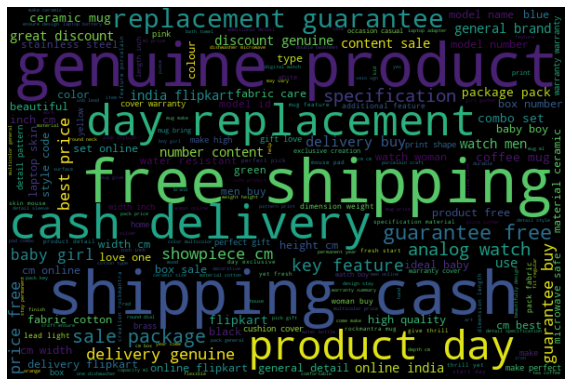


-------------------------
Delete infrequent and too frequent words in progress ...
... finished
---------
---------
Il y a 758 mots différents dans les descriptions.
Sentence example : ['key', 'feature', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'cm', 'height', 'pack', 'price', 'look', 'interior', 'make', 'high', 'quality', 'fabric', 'style', 'metal', 'room', 'love', 'anti', 'elegant', 'give', 'home', 'bright', 'appeal', 'design', 'sure', 'contemporary', 'first', 'morning', 'good', 'world', 'even', 'create', 'special', 'beauty', 'print', 'bring', 'light', 'get', 'right', 'specification', 'general', 'brand', 'type', 'model', 'name', 'set', 'id', 'color', 'dimension', 'length', 'box', 'number', 'content', 'sale', 'package', 'body', 'material']
---------


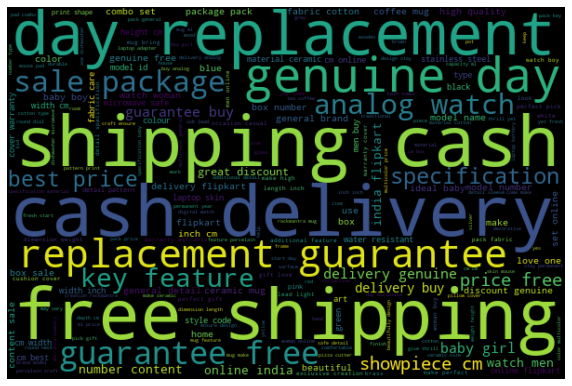

Approche Bag-of-word (cs) :
-------------------------
Nb Features text avant réduction : 758
Réduction TSNE (avec ACP)
Temps de traitement : 37.55265974998474
-------------------------
-------------------------
Delete infrequent and too frequent words in progress ...
... finished
---------
---------
Il y a 758 mots différents dans les descriptions.
Sentence example : ['key', 'feature', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'cm', 'height', 'pack', 'price', 'look', 'interior', 'make', 'high', 'quality', 'fabric', 'style', 'metal', 'room', 'love', 'anti', 'elegant', 'give', 'home', 'bright', 'appeal', 'design', 'sure', 'contemporary', 'first', 'morning', 'good', 'world', 'even', 'create', 'special', 'beauty', 'print', 'bring', 'light', 'get', 'right', 'specification', 'general', 'brand', 'type', 'model', 'name', 'set', 'id', 'color', 'dimension', 'length', 'box', 'number', 'content', 'sale', 'package', 'body', 'material']
---------


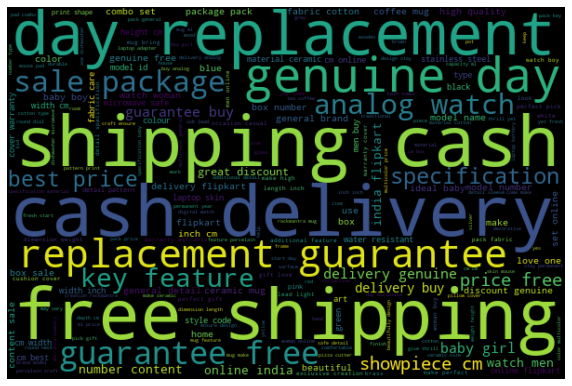

Approche Bag-of-word (tfidf) :
-------------------------
Nb Features text avant réduction : 758
Réduction TSNE (avec ACP)
Temps de traitement : 37.73355793952942
-------------------------
-------------------------
Approche Word/Sentence Embedding (w2v) :
-------------------------
Nb Features text avant réduction : 100
Réduction TSNE (sans ACP)
Temps de traitement : 41.796584129333496
-------------------------
-------------------------
Approche Word/Sentence Embedding (bert) :
-------------------------
Nb Features text avant réduction : 768
Réduction TSNE (sans ACP)
Temps de traitement : 137.11232137680054
-------------------------
-------------------------
Approche Word/Sentence Embedding (use) :
-------------------------
Nb Features text avant réduction : 512
Réduction TSNE (sans ACP)
Temps de traitement : 39.91878890991211
-------------------------
-------------------------
Approche (CNN) :
-------------------------
Nb Features text avant réduction : 4096
Réduction TSNE (avec ACP)
Te

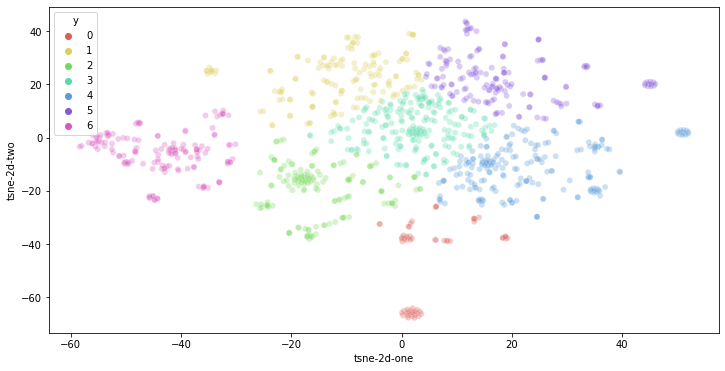

-.-.- Var Desc -.-.-
ARI : 0.3583
Time : 39.0
--------
........
--------
........
 Approche Features Image :  CNN


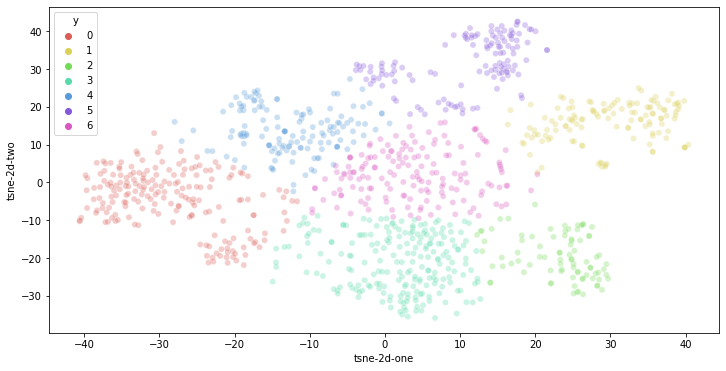

-.-.- Var Image -.-.-
ARI : 0.4674
Time : 175.0
--------
........
--------
........
 Approche Features Texte :  cs
+ Approche Features Image :  CNN


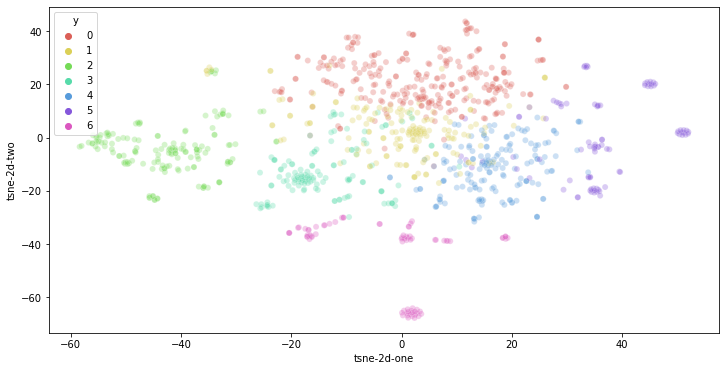

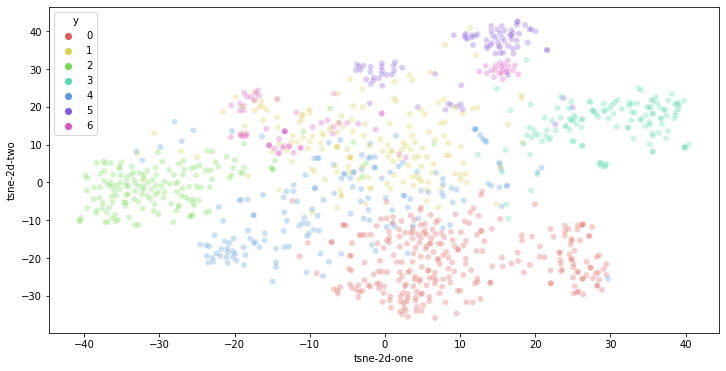

-.-.- Var Desc + Image -.-.-
ARI : 0.5164
Time : 213.0
--------
........
--------
........
 Approche Features Image :  SIFT


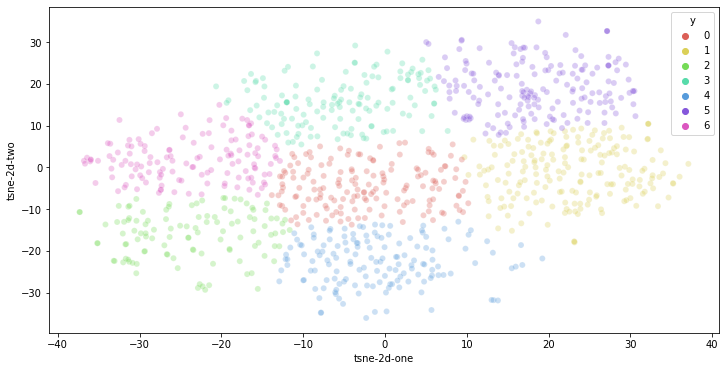

-.-.- Var Image -.-.-
ARI : 0.0606
Time : 342.0
--------
........
--------
........
 Approche Features Texte :  cs
+ Approche Features Image :  SIFT


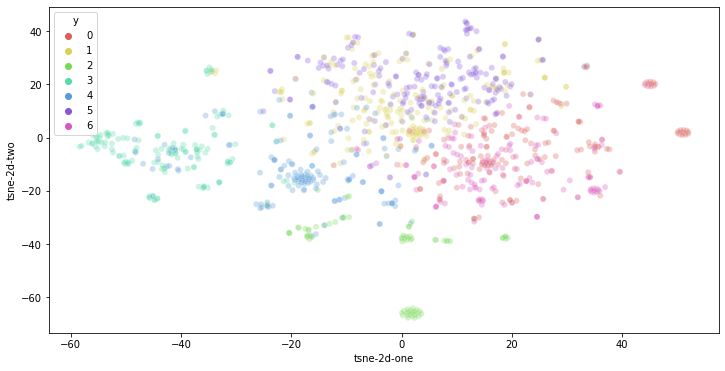

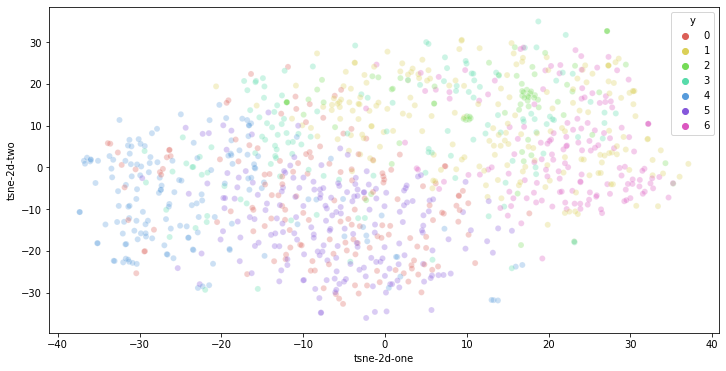

-.-.- Var Desc + Image -.-.-
ARI : 0.2932
Time : 380.0
--------
........
--------
........
 Approche Features Text :  tfidf


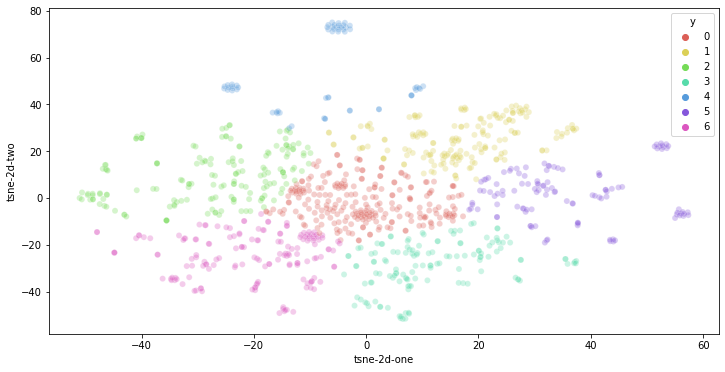

-.-.- Var Desc -.-.-
ARI : 0.2908
Time : 39.0
--------
........
--------
........
 Approche Features Texte :  tfidf
+ Approche Features Image :  CNN


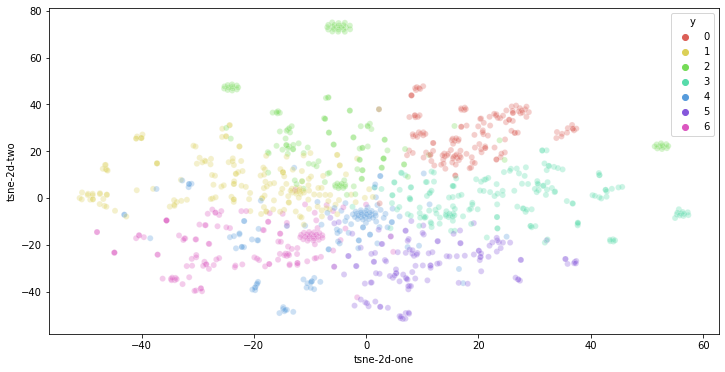

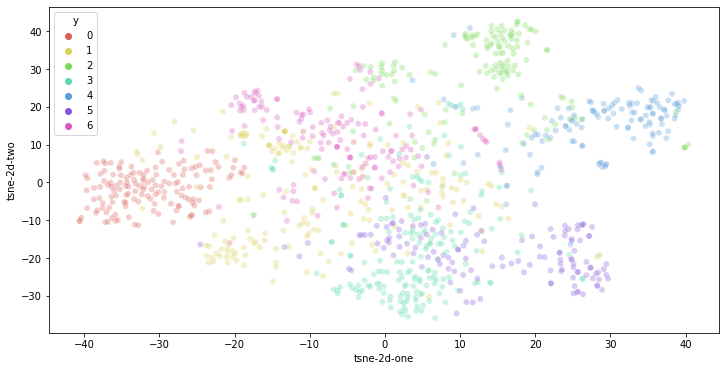

-.-.- Var Desc + Image -.-.-
ARI : 0.4844
Time : 213.0
--------
........
--------
........
 Approche Features Texte :  tfidf
+ Approche Features Image :  SIFT


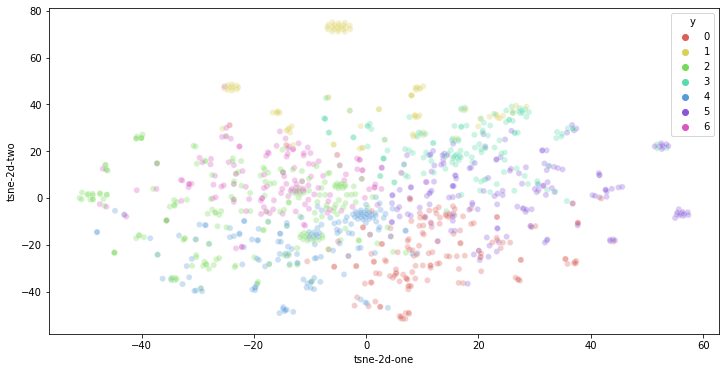

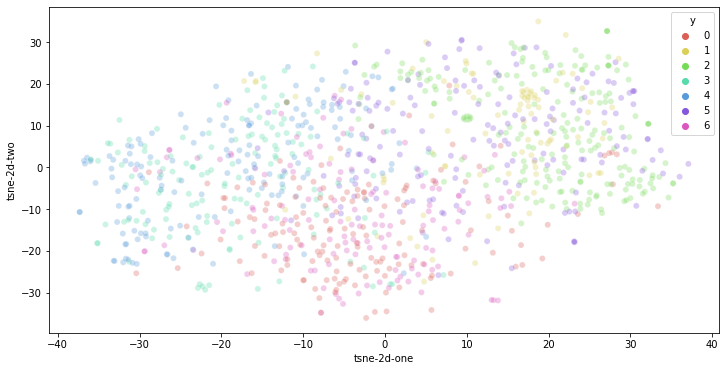

-.-.- Var Desc + Image -.-.-
ARI : 0.2293
Time : 380.0
--------
........
--------
........
 Approche Features Text :  w2v


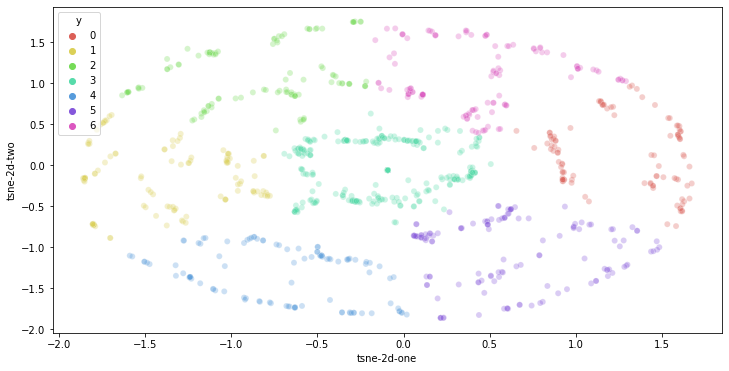

-.-.- Var Desc -.-.-
ARI : -0.0006
Time : 43.0
--------
........
--------
........
 Approche Features Texte :  w2v
+ Approche Features Image :  CNN


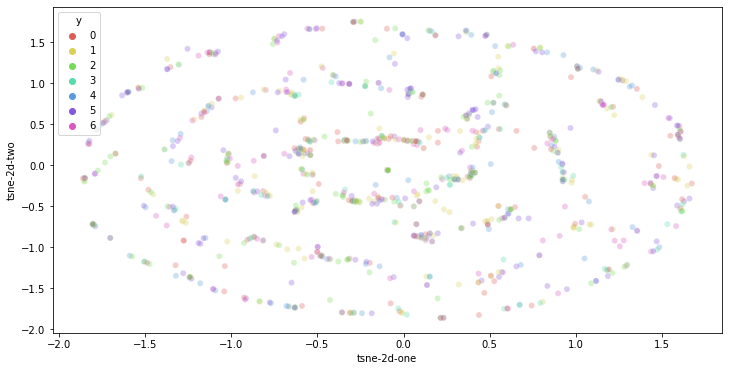

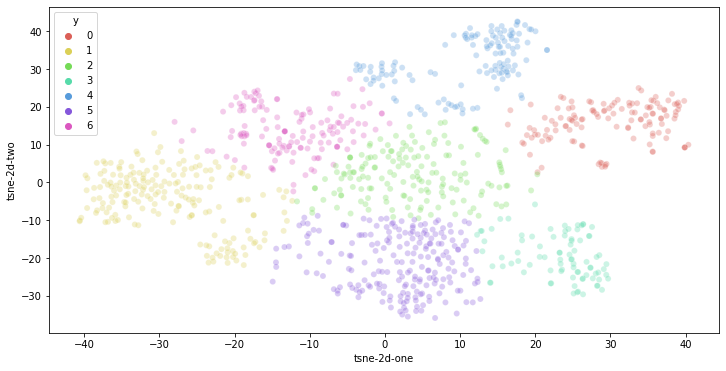

-.-.- Var Desc + Image -.-.-
ARI : 0.4676
Time : 218.0
--------
........
--------
........
 Approche Features Texte :  w2v
+ Approche Features Image :  SIFT


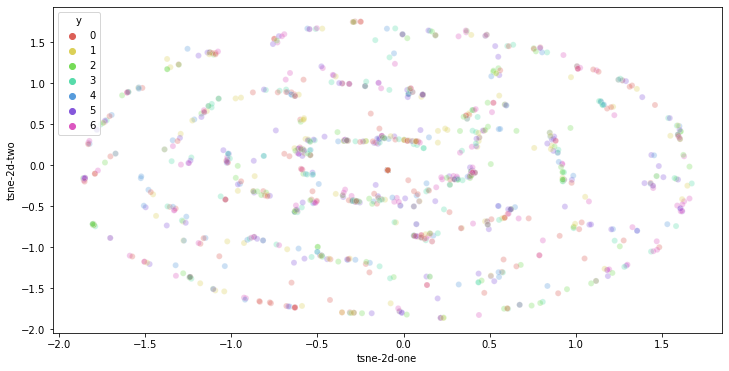

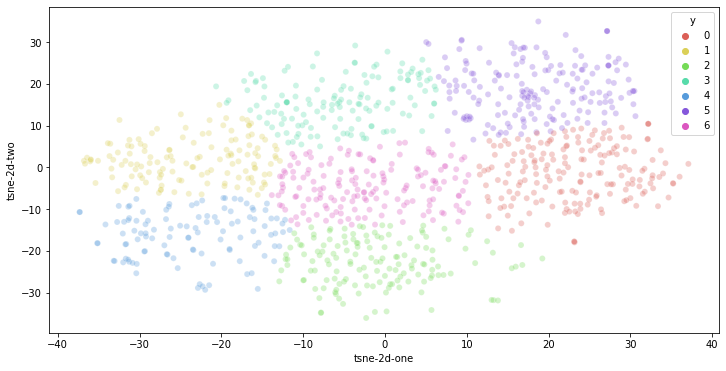

-.-.- Var Desc + Image -.-.-
ARI : 0.0603
Time : 384.0
--------
........
--------
........
 Approche Features Text :  bert


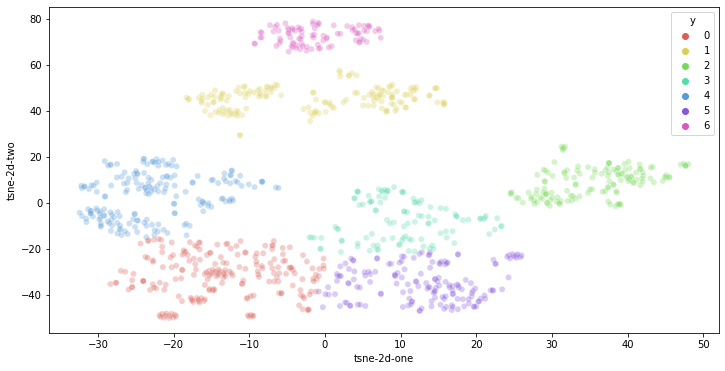

-.-.- Var Desc -.-.-
ARI : 0.3226
Time : 138.0
--------
........
--------
........
 Approche Features Texte :  bert
+ Approche Features Image :  CNN


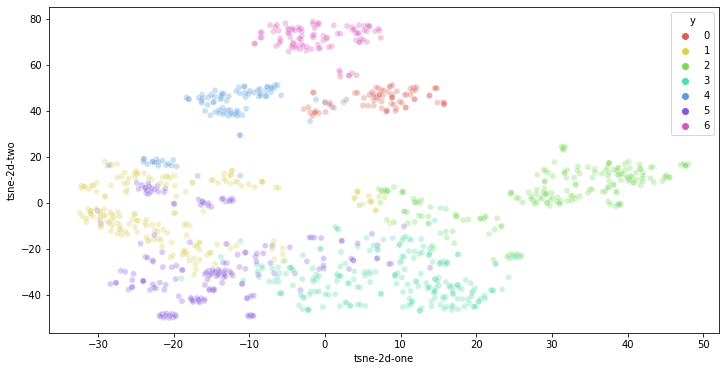

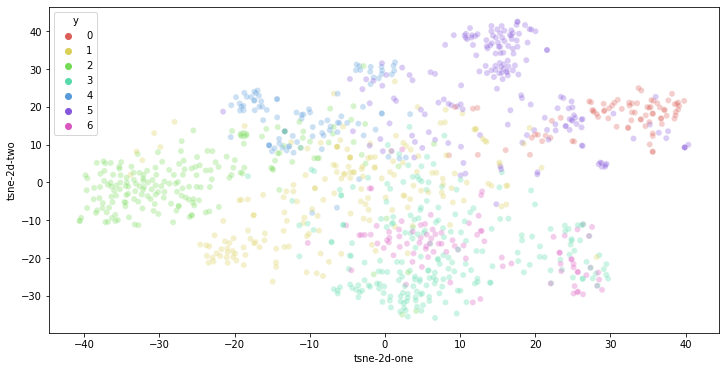

-.-.- Var Desc + Image -.-.-
ARI : 0.4131
Time : 312.0
--------
........
--------
........
 Approche Features Texte :  bert
+ Approche Features Image :  SIFT


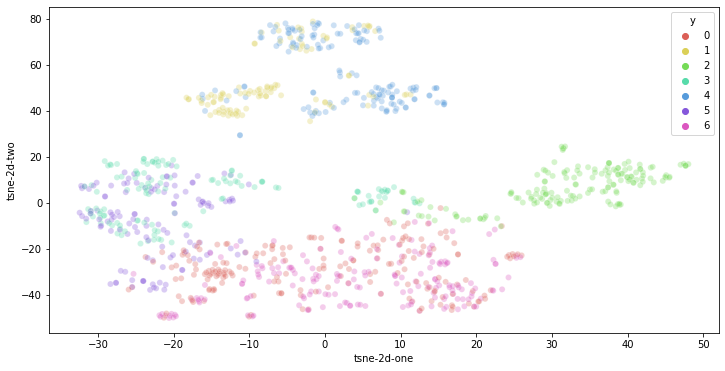

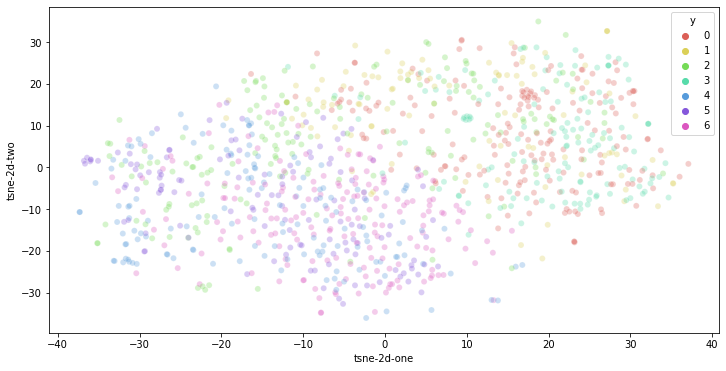

-.-.- Var Desc + Image -.-.-
ARI : 0.2598
Time : 479.0
--------
........
--------
........
 Approche Features Text :  use


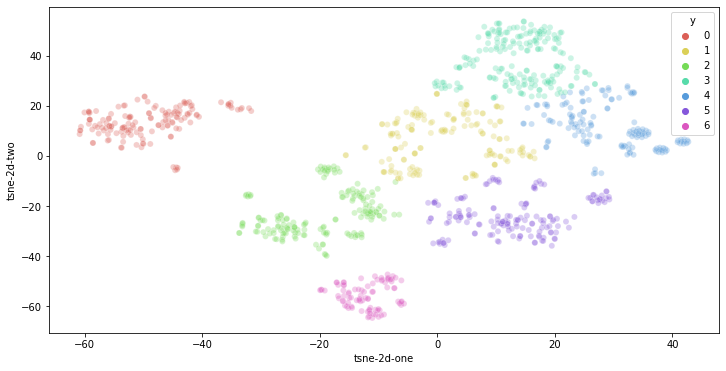

-.-.- Var Desc -.-.-
ARI : 0.4102
Time : 41.0
--------
........
--------
........
 Approche Features Texte :  use
+ Approche Features Image :  CNN


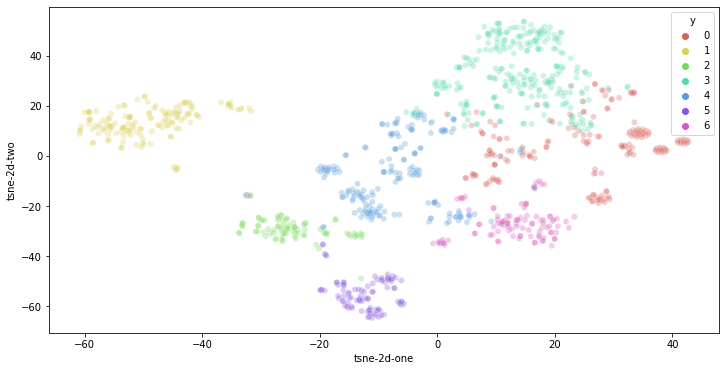

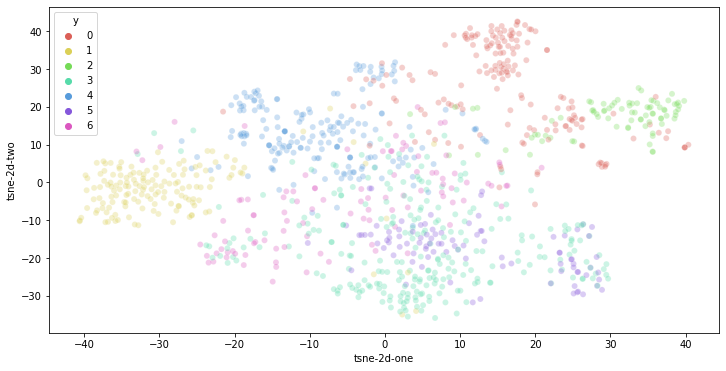

-.-.- Var Desc + Image -.-.-
ARI : 0.4668
Time : 215.0
--------
........
--------
........
 Approche Features Texte :  use
+ Approche Features Image :  SIFT


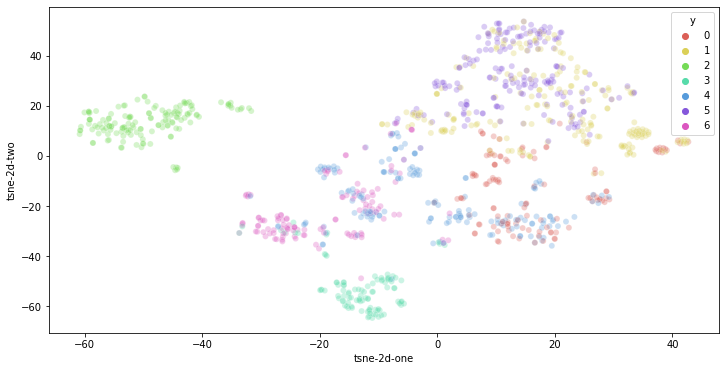

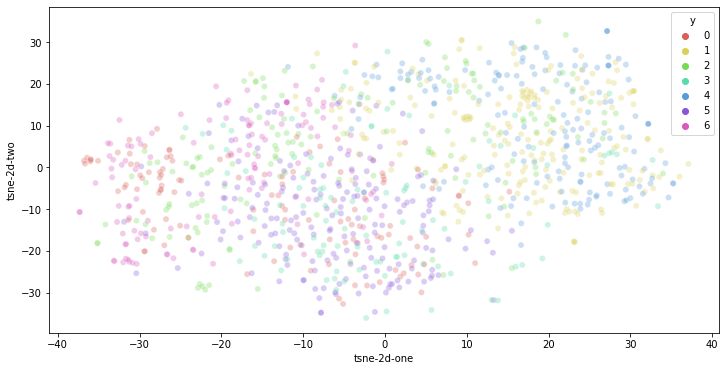

-.-.- Var Desc + Image -.-.-
ARI : 0.2867
Time : 382.0
--------
........


,Modèle,Feature Texte,Feature Picture,Reduction,Time,ARI
2,KMeans,cs,CNN,Features Text sans ACP & Features Images avec ACP,213.0000,0.5164
6,KMeans,tfidf,CNN,Features Text sans ACP & Features Images avec ACP,213.0000,0.4844
9,KMeans,w2v,CNN,Features Text sans ACP & Features Images avec ACP,218.0000,0.4676
1,KMeans,NaN,CNN,(avec ACP),175.0000,0.4674
15,KMeans,use,CNN,Features Text sans ACP & Features Images avec ACP,215.0000,0.4668
12,KMeans,bert,CNN,Features Text sans ACP & Features Images avec ACP,312.0000,0.4131
14,KMeans,use,NaN,(sans ACP),41.0000,0.4102
0,KMeans,cs,NaN,(avec ACP),39.0000,0.3583
11,KMeans,bert,NaN,(sans ACP),138.0000,0.3226
4,KMeans,cs,SIFT,Features Text sans ACP & Features Images avec ACP,380.0000,0.2932


In [32]:
df_res = classif_KMeans(df, path, list_feature_txt, list_feature_pict, n_cat, df_res)
df_res.sort_values('ARI', ascending = False)

# Conclusion et Ouverture

Les meilleurs scores tournent autour de 0.5. Le projet de moteur de classification de produit peut être faisable. Il faudrait cependant tester des approches supervisée, plus adaptée au projet afin de voir si l'on peut prédire correctement plus que la moitié des produits.